In [1]:
'''
SVC File
'''

'\nSVC File\n'

In [2]:
# Download neccesary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rdkit.Chem.PandasTools as rdk
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from deepchem.feat.smiles_tokenizer import SmilesTokenizer
from deepchem.feat.smiles_tokenizer import BasicSmilesTokenizer

In [3]:
# Download and store the dataset

dataset_path = "/Users/gaurishlakhanpal/Downloads/assay_central_tb.sdf"

dataset = rdk.LoadSDF(dataset_path)

In [4]:
dataset['SMILES'][0]

'Nc1ncnc2c1c(-c1c[nH]nn1)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O'

In [5]:
# Let's get all the unique characters first

unique_characters = []

tokenizer = BasicSmilesTokenizer()

for compound in dataset['SMILES']:
    val = tokenizer.tokenize(compound)
    for char in val:
        if(not(char in unique_characters)):
            unique_characters.append(char)

In [6]:
unique_characters

['N',
 'c',
 '1',
 'n',
 '2',
 '(',
 '-',
 '[nH]',
 ')',
 '[C@@H]',
 'O',
 '[C@H]',
 'C',
 's',
 '=',
 'F',
 '[N+]',
 '[O-]',
 'o',
 '3',
 '4',
 '5',
 '6',
 '7',
 '/',
 'Cl',
 '\\',
 'S',
 '#',
 '[n+]',
 '[S@]',
 '[C@]',
 '[C@@]',
 'I',
 '[Se]',
 '[se]',
 '[N-]',
 '[S+]',
 'P',
 '8',
 '[Na]',
 '[Si]',
 '[C-]',
 '[B-]',
 'B',
 'Br']

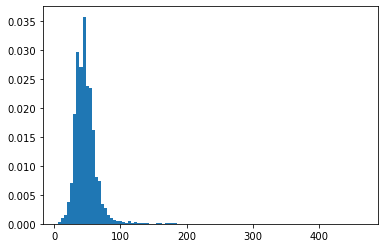

In [7]:
# Alright let's look at the length of the smiles characters 

smiles_length = []

for compounds in dataset['SMILES']:
    smiles_length.append(len(compounds))
                         
# Let's plot the lengths

plt.hist(smiles_length, density = True, bins = 100)
plt.show()

In [8]:
# Let's take values that are less than the outlier 

q1 = np.percentile(smiles_length, [25])
q2 = np.percentile(smiles_length, [50])
q3 = np.percentile(smiles_length, [75])
q4 = np.percentile(smiles_length, [99])

iqr = q3 - q1

upper_outlier_range = q3 + iqr * 1.5 
lower_outlier_range = q1 - iqr * 1.5 

print(q1)
print(q2)
print(q3)
print(q4)
print(iqr)
print(upper_outlier_range)
print(lower_outlier_range)

[37.]
[45.]
[54.]
[113.]
[17.]
[79.5]
[11.5]


In [9]:
# Let's only consider values that are not outliers in our new smiles dataset

smiles = []
smile_classes = []

counter = 0
for compound in dataset['SMILES']:
    if(len(compound) >= lower_outlier_range and len(compound) <= q4):
        smiles.append(compound)
        smile_classes.append(dataset['single-class-label'][counter])
    counter += 1

In [10]:
smiles[0:5]

['Nc1ncnc2c1c(-c1c[nH]nn1)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
 'Nc1ncnc2c1c(-c1nccs1)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
 'Nc1ncnc2c1c(-c1c[nH]cn1)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
 'Nc1ncnc2c1c(-c1ncc[nH]1)cn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O',
 'O=C(O)c1nc(O)nc(O)c1F']

In [11]:
# We can now encode this reduced dataset 

upper_outlier_range = 79 # 79.5

num_unique_characters = 37 # 37

encoding = np.zeros(shape = (upper_outlier_range, num_unique_characters))

In [12]:
# We define a function to encode our dataset

def weighted(smile_encoding, unique_chars = unique_characters):
    
    smile_encoding = tokenizer.tokenize(smile_encoding)
    
    matrix = np.zeros(shape = (1, 46))
    for i in range(len(smile_encoding)):
        matrix[0, unique_chars.index(smile_encoding[i])] += 1
        
    return (matrix)

In [13]:
enc_smiles = []

for x in smiles:
    enc_smiles.append(weighted(x))

for x in range(len(smile_classes)):
    smile_classes[x] = int(smile_classes[x])

In [14]:
# Standard Scale and format the data for later analysis

enc_smiles = np.array(enc_smiles)

nsamples, nx, ny = enc_smiles.shape
enc_smiles = enc_smiles.reshape((nsamples,nx*ny))

scaler = StandardScaler()
enc_smiles = scaler.fit_transform(enc_smiles)

In [15]:
# Let's split into test and train
# 42 is the best random state

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(enc_smiles, smile_classes, test_size = .25)

In [16]:
# Train the SVM model 

from sklearn import svm

clf = svm.SVC(kernel = "rbf", class_weight = {1:1, 0:4})
clf.fit(x_train, y_train)

SVC(class_weight={0: 4, 1: 1})

In [17]:
y_pred = clf.predict(x_test)

In [18]:
print(confusion_matrix(y_pred, y_test))
print(accuracy_score(y_pred = y_pred, y_true = y_test))
print(precision_score(y_pred = y_pred, y_true = y_test))

[[4475  150]
 [   1    4]]
0.9673866090712743
0.8


In [19]:
counter = 0
for x in range(len(y_test)):
    if(y_pred[x] == 1 and y_test[x] == 1):
        counter += 1
print(counter)

4


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Borrowed from: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(ytrue,
                          ypred,
                          labels,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''

    cf = confusion_matrix(y_true = ytrue, y_pred = ypred, labels=labels)
    
    cfn = cmn = cf.astype('float')/cf.sum(axis=1)[:, np.newaxis]

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
        group_percentages = []
        group_percentages.append(round(cf[0][0]/(cf[1][0] + cf[0][0]), 2))
        group_percentages.append(round(cf[0][1]/(cf[1][1] + cf[0][1]), 2))
        group_percentages.append(round(cf[1][0]/(cf[1][0] + cf[0][0]), 2))
        group_percentages.append(round(cf[1][1]/(cf[1][1] + cf[0][1]), 2))
        
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if(True):
            #Metrics for Binary Confusion Matrices
            
            vals = precision_recall_fscore_support(y_true = ytrue, y_pred = ypred, labels=labels, average = "weighted")
            
            precision = vals[0]
            recall    = vals[1]
            f1_score  = vals[2]
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.set(font_scale=1.4)
    sns.heatmap(cfn,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories, annot_kws={'size': 15})

    if xyplotlabels:
        plt.ylabel('True Classes', fontsize = 19)
        plt.xlabel('Predicted Classes' + stats_text, fontsize = 19)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title, fontsize = 25)

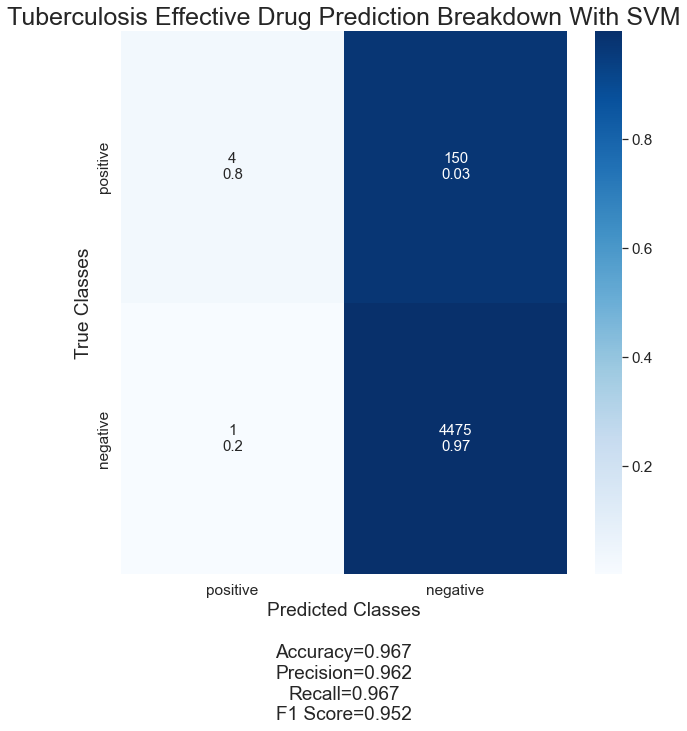

In [21]:
make_confusion_matrix(ytrue = y_test, ypred = y_pred, labels = [1, 0], categories = ['positive', 'negative'], title = "Tuberculosis Effective Drug Prediction Breakdown With SVM", figsize = (10, 10))